In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

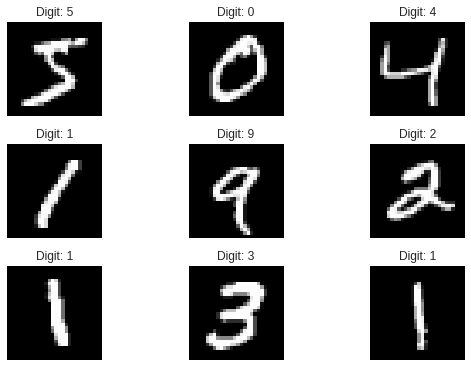

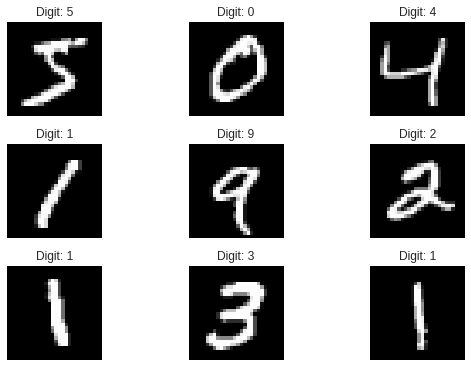

In [18]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# features, labels = next(iter(mnist))

fig = plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(X_train[i], cmap='gray', interpolation='none')
    plt.title("Digit: {}".format(y_train[i]))
    plt.xticks([])
    plt.yticks([])
fig

In [0]:
dataset_train = tf.data.Dataset.from_tensor_slices((
    tf.cast(x_train, tf.float32),
    tf.cast(y_train, tf.float32)
)).shuffle(1000).batch(64)

dataset_test = tf.data.Dataset.from_tensor_slices((
    tf.cast(x_test, tf.float32),
    tf.cast(y_test, tf.float32)
)).batch(64)

In [0]:
naive_model = tf.keras.Sequential([tf.keras.layers.Flatten(input_shape=(28, 28)),
                                   tf.keras.layers.Dense(1000, activation=tf.nn.relu, use_bias=False),
                                   tf.keras.layers.Dense(1000, activation=tf.nn.relu, use_bias=False),
                                   tf.keras.layers.Dense(500, activation=tf.nn.relu, use_bias=False),
                                   tf.keras.layers.Dense(200, activation=tf.nn.relu, use_bias=False),
                                   tf.keras.layers.Dense(10, use_bias=False)
                                 ])
# naive_model.add(Activation('softmax'))

In [0]:
def loss(naive_model, x, y):
    y_ = naive_model(x)
    return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)

In [0]:
def grad(naive_model, inputs, targets):
    with tf.GradientTape() as tape:
    loss_value = loss(naive_model, inputs, targets)
    return loss_value, tape.gradient(loss_value, naive_model.trainable_variables)

In [0]:
optimizer = tf.train.AdamOptimizer()
global_step = tf.train.get_or_create_global_step()

In [0]:
loss_value, grads = grad(model, features, labels)

print("Step: {}, Initial Loss: {}".format(global_step.numpy(),
                                          loss_value.numpy()))

optimizer.apply_gradients(zip(grads, model.trainable_variables), global_step)

print("Step: {},         Loss: {}".format(global_step.numpy(),
                                          loss(model, features, labels).numpy()))

In [36]:
from tensorflow import contrib
tfe = contrib.eager

train_loss_results = []
train_accuracy_results = []

epoch_num = 25

for epoch in range(epoch_num):
    epoch_loss_avg = tfe.metrics.Mean()
    epoch_accuracy = tfe.metrics.Accuracy()
    
    for x, y in (dataset_train):
        loss_value, grads = grad(naive_model, x, y)
        optimizer.apply_gradients(zip(grads, model.trainable_variables),global_step)  
        
        epoch_loss_avg(loss_value)  
        epoch_accuracy(tf.argmax(model(x), axis=1, output_type=tf.int32), y)
    
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    if epoch % 50 == 0:
        print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))
        
#         with tf.GradientTape() as tape:
#             outputs = model(x)
#             loss = tf.losses.softmax_cross_entropy(tf.one_hot(y, 10), outputs)
#         grads = tape.gradient(loss, model.trainable_weights)
#         optimizer.apply_gradients(zip(grads, model.trainable_weights), global_step)
#         epoch_loss_avg(loss)
#         epoch_accuracy(tf.argmax(outputs, axis=1, output_type=tf.int64), y)
#     training_losses.append(epoch_loss_avg.result())
#     training_accuracies.append(epoch_accuracy.result())

  0%|          | 0/938 [00:00<?, ?it/s]

RuntimeError: ignored

In [0]:
epoch_loss_avg = tf.contrib.eager.metrics.Mean()
epoch_accuracy = tf.contrib.eager.metrics.Accuracy()
for x, y in dataset:
    outputs = naive_model(x)
    loss = tf.losses.softmax_cross_entropy(tf.one_hot(y, 10), outputs)
    epoch_loss_avg(loss)
    epoch_accuracy(tf.argmax(outputs, axis=1, output_type=tf.int64), y)
    epoch_loss_avg.result().numpy(), epoch_accuracy.result().numpy()


In [0]:
plt.figure(1, figsize=(15,6))
plt.subplots_adjust(hspace=0.5)
for i, weights in enumerate(model.trainable_weights):
    plt.subplot(3,2,i+1)
    plt.title("Layer {}".format(i+1))
    plt.hist(weights.numpy().reshape(-1), bins=100)
    plt.xlim(-0.5, 0.5);